In [38]:
# Importing necessary libraries
import os
import sys
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from core.kernel import ARDKernel
import torch.optim as optim
import core.GP_CommonCalculation as GP

# Constants
JITTER = 1e-3
PI = 3.1415
torch.manual_seed(4)

# Function to create and initialize model parameters
def create_model(X, Y, num_inducing):
    data = GP.XYdata_normalization(X, Y, 0)
    X_all, Y_all = data.normalize(X, Y)
    kernel = ARDKernel(1)
    
    xm = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64)) # Inducing points
    qu_mean = nn.Parameter(torch.zeros(num_inducing, 1, dtype=torch.float64))
    chole = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64))
    log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64) * 0)

    return X_all, Y_all, kernel, xm, qu_mean, chole, log_beta


In [39]:
# Function to get a new batch of data
def new_batch(X_all, Y_all, dataloader, iterator):
    try:
        X_batch, Y_batch = next(iterator)
    except StopIteration:
        iterator = iter(dataloader)
        X_batch, Y_batch = next(iterator)
    return X_batch, Y_batch, iterator

In [40]:
# Function to compute variational loss
def variational_loss(X, Y, xm, qu_mean, chole, log_beta, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_mn = kernel(xm, X)
    K_nm = K_mn.t()
    qu_S = chole @ chole.t() + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Ls = torch.linalg.cholesky(qu_S)
    K_nn = kernel(X, X).diag()
    batch_size = X.size(0)
    mean_vector = K_nm @ K_mm_inv @ qu_mean
    precision = 1 / log_beta.exp()
    K_tilde = precision * (K_nn - (K_nm @ K_mm_inv @ K_mn).diag())
    K_nm_expanded = K_nm.unsqueeze(2)
    K_nm_transposed = K_nm_expanded.transpose(1, 2)
    lambda_mat = torch.matmul(K_nm_expanded, K_nm_transposed)
    lambda_mat = K_mm_inv @ lambda_mat @ K_mm_inv
    batch_matrices = qu_S @ lambda_mat
    traces = precision * torch.einsum('bii->b', batch_matrices)
    
    likelihood_sum = -0.5 * batch_size * torch.log(2 * torch.tensor(PI)) + 0.5 * batch_size * torch.log(log_beta.exp()) - 0.5 * log_beta.exp() * ((Y - K_nm @ K_mm_inv @ qu_mean) ** 2).sum(dim=0).view(-1, 1) - 0.5 * torch.sum(K_tilde) - 0.5 * torch.sum(traces)
    
    logdetS = 2 * Ls.diag().abs().log().sum()
    logdetKmm = 2 * Lm.diag().abs().log().sum()
    KL = 0.5 * (K_mm_inv @ qu_S).diag().sum(dim=0).view(-1, 1) + 0.5 * (qu_mean.t() @ K_mm_inv @ qu_mean) - 0.5 * logdetS + 0.5 * logdetKmm - 0.5 * xm.size(0)
    return likelihood_sum, KL, mean_vector

In [41]:
# Function to evaluate the model
def forward(Xte, xm, qu_mean, chole, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_tt = kernel(Xte, Xte)
    K_tm = kernel(Xte, xm)
    K_mt = K_tm.t()
    A = K_tm @ K_mm_inv
    mean = A @ qu_mean
    yvar = K_tt - K_tm @ K_mm_inv @ K_mt + K_tm @ K_mm_inv @ (chole @ chole.t()) @ K_mm_inv @ K_mt
    yvar = yvar.diag().view(-1, 1)
    return mean, yvar

In [42]:
# Initialize training and test data
torch.manual_seed(4)
num_data = 10000
xtr = torch.rand(num_data, 1, dtype=torch.float64)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(num_data, 1, dtype=torch.float64) * 0.1
xte = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)
normalizer = GP.XYdata_normalization(xtr, ytr, 0)
x_normalized, y_normalized = normalizer.normalize(xtr, ytr)
xte_normalized = normalizer.normalize(xte)

In [47]:
# Model parameters
num_inducing =20
batch_size = 200
learning_rate = 0.1
num_epochs = 500

# Create model
X_all, Y_all, kernel, xm, qu_mean, chole, log_beta = create_model(x_normalized, y_normalized, num_inducing)
dataset = TensorDataset(X_all, Y_all)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
iterator = iter(dataloader)
optimizer = torch.optim.Adam(list(kernel.parameters())+[xm, qu_mean, chole, log_beta], lr=learning_rate)

# Training loop
for i in range(num_epochs):
    optimizer.zero_grad()
    X_batch, Y_batch, iterator = new_batch(X_all, Y_all, dataloader, iterator)
    likelihood, KL, _ = variational_loss(X_batch, Y_batch, xm, qu_mean, chole, log_beta, kernel)
    loss = KL - likelihood * num_data / batch_size  # Negative ELBO
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:27444.40831
iter 10 nll:9034.97710
iter 20 nll:6578.88412
iter 30 nll:2235.38828
iter 40 nll:-2735.07880
iter 50 nll:-3165.24988
iter 60 nll:-725.53647
iter 70 nll:1119.45719
iter 80 nll:-3112.85097
iter 90 nll:-2871.32192
iter 100 nll:-9295.89045
iter 110 nll:-10275.50413
iter 120 nll:-3971.01827
iter 130 nll:-3369.84585
iter 140 nll:-4747.85385
iter 150 nll:-8131.84322
iter 160 nll:-11791.28976
iter 170 nll:-14889.95685
iter 180 nll:-13962.38560
iter 190 nll:-12176.30739
iter 200 nll:-14063.82183
iter 210 nll:-14114.12619
iter 220 nll:-17140.75187
iter 230 nll:-11836.65670
iter 240 nll:-7199.58693
iter 250 nll:-6406.76373
iter 260 nll:-7341.64000
iter 270 nll:-9316.87062
iter 280 nll:-11409.71346
iter 290 nll:-13427.78418
iter 300 nll:-15559.30802
iter 310 nll:-17369.16588
iter 320 nll:-18611.13027
iter 330 nll:-18235.52078
iter 340 nll:-19849.47059
iter 350 nll:-17895.16765
iter 360 nll:-17229.35746
iter 370 nll:-14661.09111
iter 380 nll:-11563.89291
iter 390 nll:-16082.5

Test MSE: 0.019174846840062584


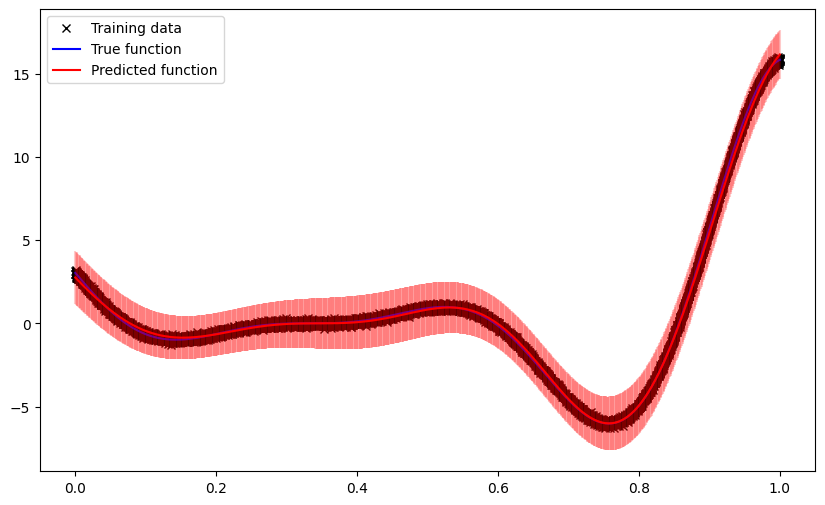

In [48]:
# Evaluate the model
with torch.no_grad():
    predictions, yvar = forward(xte_normalized, xm, qu_mean, chole, kernel)
    predictions, yvar = normalizer.denormalize_y(predictions, yvar)
    mse = torch.mean((predictions - yte) ** 2)
    print(f'Test MSE: {mse.item()}')

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(xtr.numpy(), ytr.numpy(), 'kx', label='Training data')
plt.plot(xte.numpy(), yte.numpy(), 'b', label='True function')
plt.plot(xte.numpy(), predictions.numpy(), 'r', label='Predicted function')
plt.errorbar(xte.numpy().reshape(1000), predictions.detach().numpy().reshape(1000),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.legend()
plt.show()